# Road Flow Visualization by Country

This notebook analyzes and visualizes road network flows for a selected country. It integrates OD (Origin-Destination) matrices, road network data, and country boundaries to provide insights into the distribution and magnitude of flows for different vehicle types (cars, trucks, buses). The workflow includes data loading, OD matrix preparation, capacity estimation, flow assignment, per-edge vehicle estimation, visualization, and summary statistics. The output includes maps and tables summarizing flows for each road segment, with a focus on the selected country.

## 1. Imports and Configuration

This section imports all necessary Python libraries and utility functions, and loads the country boundaries dataset. It ensures the spatial data is in the correct coordinate reference system and filters the boundaries to the European region, preparing the context for subsequent road flow analysis.

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import igraph as ig
import warnings
from pathlib import Path
import os
from collections import defaultdict, deque
from itertools import chain
import matplotlib.lines as mlines
import sys

sys.path.append(str(Path().resolve().parent))

from utils.miraca_flow_utils import compute_travel_time_kh, pick_col, map_stations_to_nodes, compute_edge_capacity,  compute_edge_capacity_cars, ensure_series, find_minimal_flows_along_overcapacity_paths, get_path_indexes_for_edges, od_flow_allocation_capacity_constrained
from utils.miraca_flow_utils import get_flow_paths_indexes_of_edges, get_flow_on_edges, update_flow_and_overcapacity, create_igraph_from_dataframe, network_od_path_estimations_multiattribute, network_od_paths_assembly_multiattributes
from utils.miraca_flow_utils import plot_edges_by_flow_thickness, od_road_creation

warnings.filterwarnings('ignore')

base_path = Path(os.path.dirname(os.getcwd()) + "/data")
outpath = Path(os.path.dirname(os.getcwd()) + "/output")

# Load country boundaries
countries_gdf = gpd.read_file(base_path / "helpers" / "ne_10m_admin_0_countries.shp")

# Ensure CRS is WGS84
if countries_gdf.crs is None:
    countries_gdf = countries_gdf.set_crs(4326)
elif countries_gdf.crs.to_epsg() != 4326:
    countries_gdf = countries_gdf.to_crs(4326)

# Filter to Europe region
europe_bounds = {"xmin": -12, "xmax": 32, "ymin": 35, "ymax": 72}
europe_countries = countries_gdf.cx[
    europe_bounds["xmin"]:europe_bounds["xmax"], 
    europe_bounds["ymin"]:europe_bounds["ymax"]
].copy()

print(f"Loaded {len(europe_countries)} countries in Europe region")

Loaded 54 countries in Europe region


## 2. Load data and prepare OD matrices

This section loads the road network data, including edges and nodes, and OD (Origin-Destination) matrices for cars, trucks, and buses. It prepares the OD data for further analysis by cleaning and formatting the relevant columns, and creates a merged OD matrix with PCU equivalents and vehicle shares.

In [3]:
print('Loading road data...')
edges_gdf = gpd.read_parquet(base_path / "Infra_BE/belgium_road_edges.parquet").to_crs("EPSG:4326")
nodes_gdf = gpd.read_parquet(base_path / "Infra_BE/belgium_road_nodes.parquet").to_crs("EPSG:4326")
od_flows_trucks = pd.read_parquet(base_path / "ODs_BE/belgium_road_trucks_OD.parquet")
od_flows_cars = pd.read_parquet(base_path / "ODs_BE/belgium_road_cars_OD.parquet")
od_flows_buses = pd.read_parquet(base_path / "ODs_BE/belgium_road_buses_OD.parquet")

if edges_gdf.crs is None: edges_gdf.set_crs('EPSG:4326', inplace=True, allow_override=True)
if nodes_gdf.crs is None: nodes_gdf.set_crs('EPSG:4326', inplace=True, allow_override=True)
print('Data loaded.')

edges_gdf = compute_travel_time_kh(edges_gdf, speed_col='tag_maxspeed')
edge_src = pick_col(edges_gdf, ['from_id'])
edge_dst = pick_col(edges_gdf, ['to_id'])
node_id_col = pick_col(nodes_gdf, ['id'])

# Prepare OD data
od_trucks = od_flows_trucks.copy()
od_cars = od_flows_cars.copy()
od_buses = od_flows_buses.copy()

od_cars['from_node'] = od_cars['origin_node'].astype(str)
od_cars['to_node']   = od_cars['dest_node'].astype(str)
od_cars = od_cars.dropna(subset=['from_node','to_node'])
od_cars['from_node'] = od_cars['from_node'].astype(str)
od_cars['to_node']   = od_cars['to_node'].astype(str)
od_cars['cars_vehicles']     = pd.to_numeric(od_cars['cars_vehicles'], errors='coerce').fillna(0.0)
# Drop original node columns to avoid confusion
od_cars = od_cars.drop(columns=['origin_node', 'dest_node'], errors='ignore')
od_cars = od_cars[od_cars['cars_vehicles'] > 0]


od_buses['from_node'] = od_buses['origin_node'].astype(str)
od_buses['to_node']   = od_buses['dest_node'].astype(str)
od_buses = od_buses.dropna(subset=['from_node','to_node'])
od_buses['from_node'] = od_buses['from_node'].astype(str)
od_buses['to_node']   = od_buses['to_node'].astype(str)
od_buses['buses_vehicles']     = pd.to_numeric(od_buses['buses_vehicles'], errors='coerce').fillna(0.0)
# Drop original node columns to avoid confusion
od_buses = od_buses.drop(columns=['origin_node', 'dest_node'], errors='ignore')
od_buses = od_buses[od_buses['buses_vehicles'] > 0]


od_trucks['from_node'] = od_trucks['from_id'].astype(str)
od_trucks['to_node']   = od_trucks['to_id'].astype(str)
od_trucks = od_trucks.dropna(subset=['from_node','to_node'])
od_trucks['from_node'] = od_trucks['from_node'].astype(str)
od_trucks['to_node']   = od_trucks['to_node'].astype(str)
od_trucks['trucks_per_year']     = pd.to_numeric(od_trucks['trucks_per_year'], errors='coerce').fillna(0.0)
# Drop original node columns to avoid confusion
od_trucks = od_trucks.drop(columns=['origin_node', 'dest_node'], errors='ignore')
od_trucks = od_trucks[od_trucks['trucks_per_year'] > 0]

# --- Create vehicles OD matrix with PCU equivalents and shares ---
# PCU factors
pcu_cars = 1.0
pcu_trucks = 3.0
pcu_buses = 3.0

vehicles_od_pcu = od_road_creation(od_cars, od_buses, od_trucks, pcu_cars, pcu_buses, pcu_trucks)

Loading road data...
Data loaded.
Data loaded.


## 3. Compute Capacities and plot them

This section estimates per-edge vehicle capacities based on operational assumptions and traffic composition. It visualizes the number of vehicles per edge and sets up the network for flow assignment.

Traffic composition:
  Cars:   98.99% (2,772,355,295)
  Trucks: 0.54% (15,124,530)
  Buses:  0.47% (13,234,140)


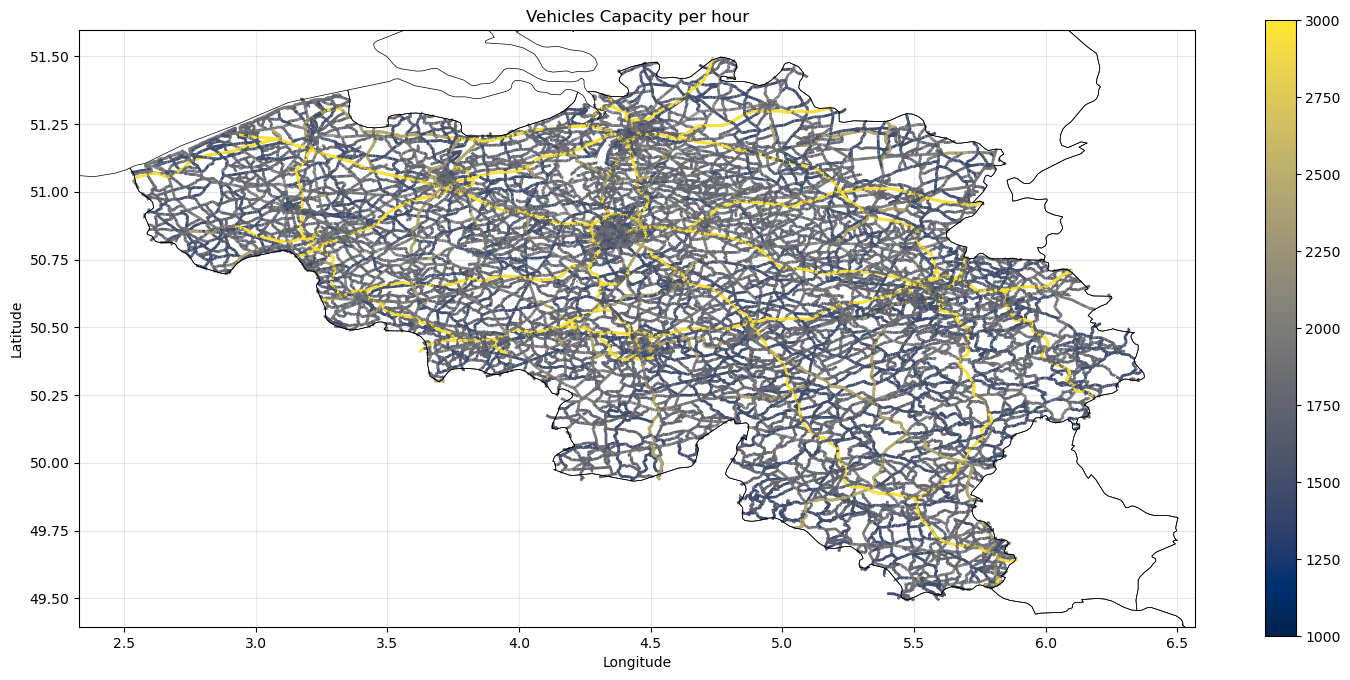

In [4]:
edges_gdf = edges_gdf.copy()
edges_gdf['edge_id'] = np.arange(len(edges_gdf), dtype=int)

network_df = pd.DataFrame({
    'from_node': edges_gdf[edge_src].astype(str).values,
    'to_node':   edges_gdf[edge_dst].astype(str).values,
    'edge_id':   edges_gdf['edge_id'].values,
    'travel_time': pd.to_numeric(edges_gdf['travel_time'], errors='coerce').fillna(1.0).astype(float).values,
    'CORRIDORS': edges_gdf['CORRIDORS'].values
})
      
network_df['pcu_flow'] = 0.0
network_df['cars'] = 0.0
network_df['buses'] = 0.0
network_df['trucks'] = 0.0

# --- Compute traffic composition from OD matrices ---
total_cars = od_cars['cars_vehicles'].sum() if 'cars_vehicles' in od_cars.columns else 0.0
total_trucks = od_trucks['trucks_per_year'].sum() if 'trucks_per_year' in od_trucks.columns else 0.0
total_buses = od_buses['buses_vehicles'].sum() if 'buses_vehicles' in od_buses.columns else 0.0
total_vehicles = total_cars + total_trucks + total_buses
if total_vehicles > 0:
    share_cars = total_cars / total_vehicles
    share_trucks = total_trucks / total_vehicles
    share_buses = total_buses / total_vehicles
else:
    share_cars = share_trucks = share_buses = 0.0
print(f"Traffic composition:")
print(f"  Cars:   {share_cars:.2%} ({total_cars:,.0f})")
print(f"  Trucks: {share_trucks:.2%} ({total_trucks:,.0f})")
print(f"  Buses:  {share_buses:.2%} ({total_buses:,.0f})")

cap_vehicles = compute_edge_capacity_cars(edges_gdf, tt_col='travel_time', share_cars = share_cars, share_trucks=share_trucks, share_buses=share_buses)
cap_arr_vehicles = np.asarray(cap_vehicles, dtype=float)
cap_arr_vehicles = np.where(np.isfinite(cap_arr_vehicles), cap_arr_vehicles, 0.0)
network_df['capacity_vehicles'] = cap_arr_vehicles

edges_gdf_copy = edges_gdf.copy()
edges_gdf_copy['num_vehicles'] = network_df['capacity_vehicles']/(300*24)

fig, ax = plt.subplots(1, 1, figsize=(18, 8))
# Get Belgium geometry and bounds
belgium_row = europe_countries[europe_countries['NAME'].str.lower() == 'belgium']
minx, miny, maxx, maxy = belgium_row.total_bounds
margin_x = (maxx - minx) * 0.05
margin_y = (maxy - miny) * 0.05
xlim = (minx - margin_x, maxx + margin_x)
ylim = (miny - margin_y, maxy + margin_y)

# Plot Vehicles
edges_gdf_copy.plot(ax=ax, column='num_vehicles', cmap='cividis', linewidth=2, legend=True, vmin=1000, vmax=3000)
europe_countries.boundary.plot(ax=ax, color='black', linewidth=0.5)
ax.set_title('Vehicles Capacity per hour')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.grid(True, alpha=0.3)

## 4. Create network

This section builds the road network graph, filters edges by capacity, and prepares the network for flow assignment and further analysis.

In [5]:
thr_capacity = 1
# Filter out edges with capacity below threshold
network_df_filtered = network_df[(network_df['capacity_vehicles'] >= thr_capacity)].copy()
edges_gdf_copy = edges_gdf[edges_gdf['edge_id'].isin(network_df_filtered['edge_id'])].copy()
edges_gdf_copy = edges_gdf_copy.merge(
    network_df_filtered[['edge_id', 'capacity_vehicles']],
    on='edge_id', how='left'
    )

base_graph = ig.Graph.TupleList(
    network_df_filtered[['from_node', 'to_node', 'edge_id', 'travel_time']].itertuples(index=False, name=None),
    edge_attrs=['edge_id', 'travel_time'],
    directed=False
)

print(f"Network: {base_graph.vcount()} nodes, {base_graph.ecount()} edges in igraph object.")

# total capacities
total_cap_vehicles = network_df_filtered['capacity_vehicles'].sum()
print(f"Total Vehicle Capacity per year: {total_cap_vehicles:,.2f}")


Network: 162308 nodes, 187122 edges in igraph object.
Total Vehicle Capacity per year: 2,517,337,642,159.49


## 5. Assign flows to the network

This section assigns flows to the road network using a capacity-constrained allocation algorithm. It aggregates the assigned flows per edge, estimates the number of each vehicle type per edge, and merges the results into the network dataframe.

In [6]:
# Run capacity-constrained allocation for road vehicles
capacity_ods_vehicles, unassigned_paths_vehicles, filtered_network_df, progress_df = od_flow_allocation_capacity_constrained(
    flow_ods=vehicles_od_pcu,
    network_dataframe=network_df_filtered,
    flow_column='pcu_flow',
    cost_column='travel_time',
    path_id_column='edge_id',
    attribute_list=None,
    origin_id_column='from_node',
    destination_id_column='to_node',
    network_capacity_column='capacity_vehicles',
    directed=False,
    simple=False,
    store_edge_path=True,
    graph_base=base_graph,
    track_progress=True,
    early_stop_share=0.95
)

# Aggregate assigned flows per edge
if isinstance(capacity_ods_vehicles, list):
    assigned_df = pd.concat(capacity_ods_vehicles, ignore_index=True)
else:
    assigned_df = capacity_ods_vehicles

# Get total assigned trips per edge
assigned_vehicles_on_edges = get_flow_on_edges(assigned_df, 'edge_id', 'edge_path', 'pcu_flow')

# Merge back into filtered_network_df
filtered_network_df = filtered_network_df.merge(
    assigned_vehicles_on_edges.rename(columns={'pcu_flow': 'assigned_vehicles'}),
    on='edge_id', how='left'
)

# Fill NaN with 0 for assigned flows
filtered_network_df['assigned_vehicles'] = filtered_network_df['assigned_vehicles'].fillna(0.0)

# Ensure filtered_network_df has geometry
filtered_network_df = filtered_network_df.merge(
    edges_gdf[['edge_id', 'geometry']],
    on='edge_id',
    how='left'
)

# --- Estimate number of cars, trucks, and buses per edge after allocation ---
# This assumes assigned_df contains columns: from_node, to_node, pcu_flow (assigned), edge_path
# and vehicles_od_pcu contains: from_node, to_node, share_cars, share_trucks, share_buses
# Merge shares into assigned_df for each OD pair
assigned_df = assigned_df.merge(vehicles_od_pcu[['from_node','to_node','share_cars','share_trucks','share_buses']],
                                    on=['from_node','to_node'], how='left')
# For each row (OD-edge assignment), estimate vehicle flows
assigned_df['cars_on_edge'] = assigned_df['pcu_flow'] * assigned_df['share_cars'] / pcu_cars
assigned_df['trucks_on_edge'] = assigned_df['pcu_flow'] * assigned_df['share_trucks'] / pcu_trucks
assigned_df['buses_on_edge'] = assigned_df['pcu_flow'] * assigned_df['share_buses'] / pcu_buses
assigned_df = assigned_df.explode('edge_path')
assigned_df = assigned_df.rename(columns={'edge_path': 'edge_id'})
assigned_df['edge_id'] = assigned_df['edge_id'].astype(int)
# Now sum per edge
edge_vehicle_counts = assigned_df.groupby('edge_id').agg({
    'cars_on_edge': 'sum',
    'trucks_on_edge': 'sum',
    'buses_on_edge': 'sum',
    'pcu_flow': 'sum'
}).reset_index()

# Merge into filtered_network_df
filtered_network_df = filtered_network_df.merge(edge_vehicle_counts, on='edge_id', how='left')
filtered_network_df[['cars_on_edge','trucks_on_edge','buses_on_edge']] = filtered_network_df[['cars_on_edge','trucks_on_edge','buses_on_edge']].fillna(0.0)

[progress] iter=0 assigned_iter=2638876724.000 cum=2638876724.000 (0.9235) remaining=218554581.000 overcap_edges=0 next_flows=0


## 7. Create Flow Visualization

This section visualizes the assigned flows for all vehicles and by vehicle type (cars, trucks, buses) on the road network using maps. It also prints summary statistics for per-edge vehicle flows.

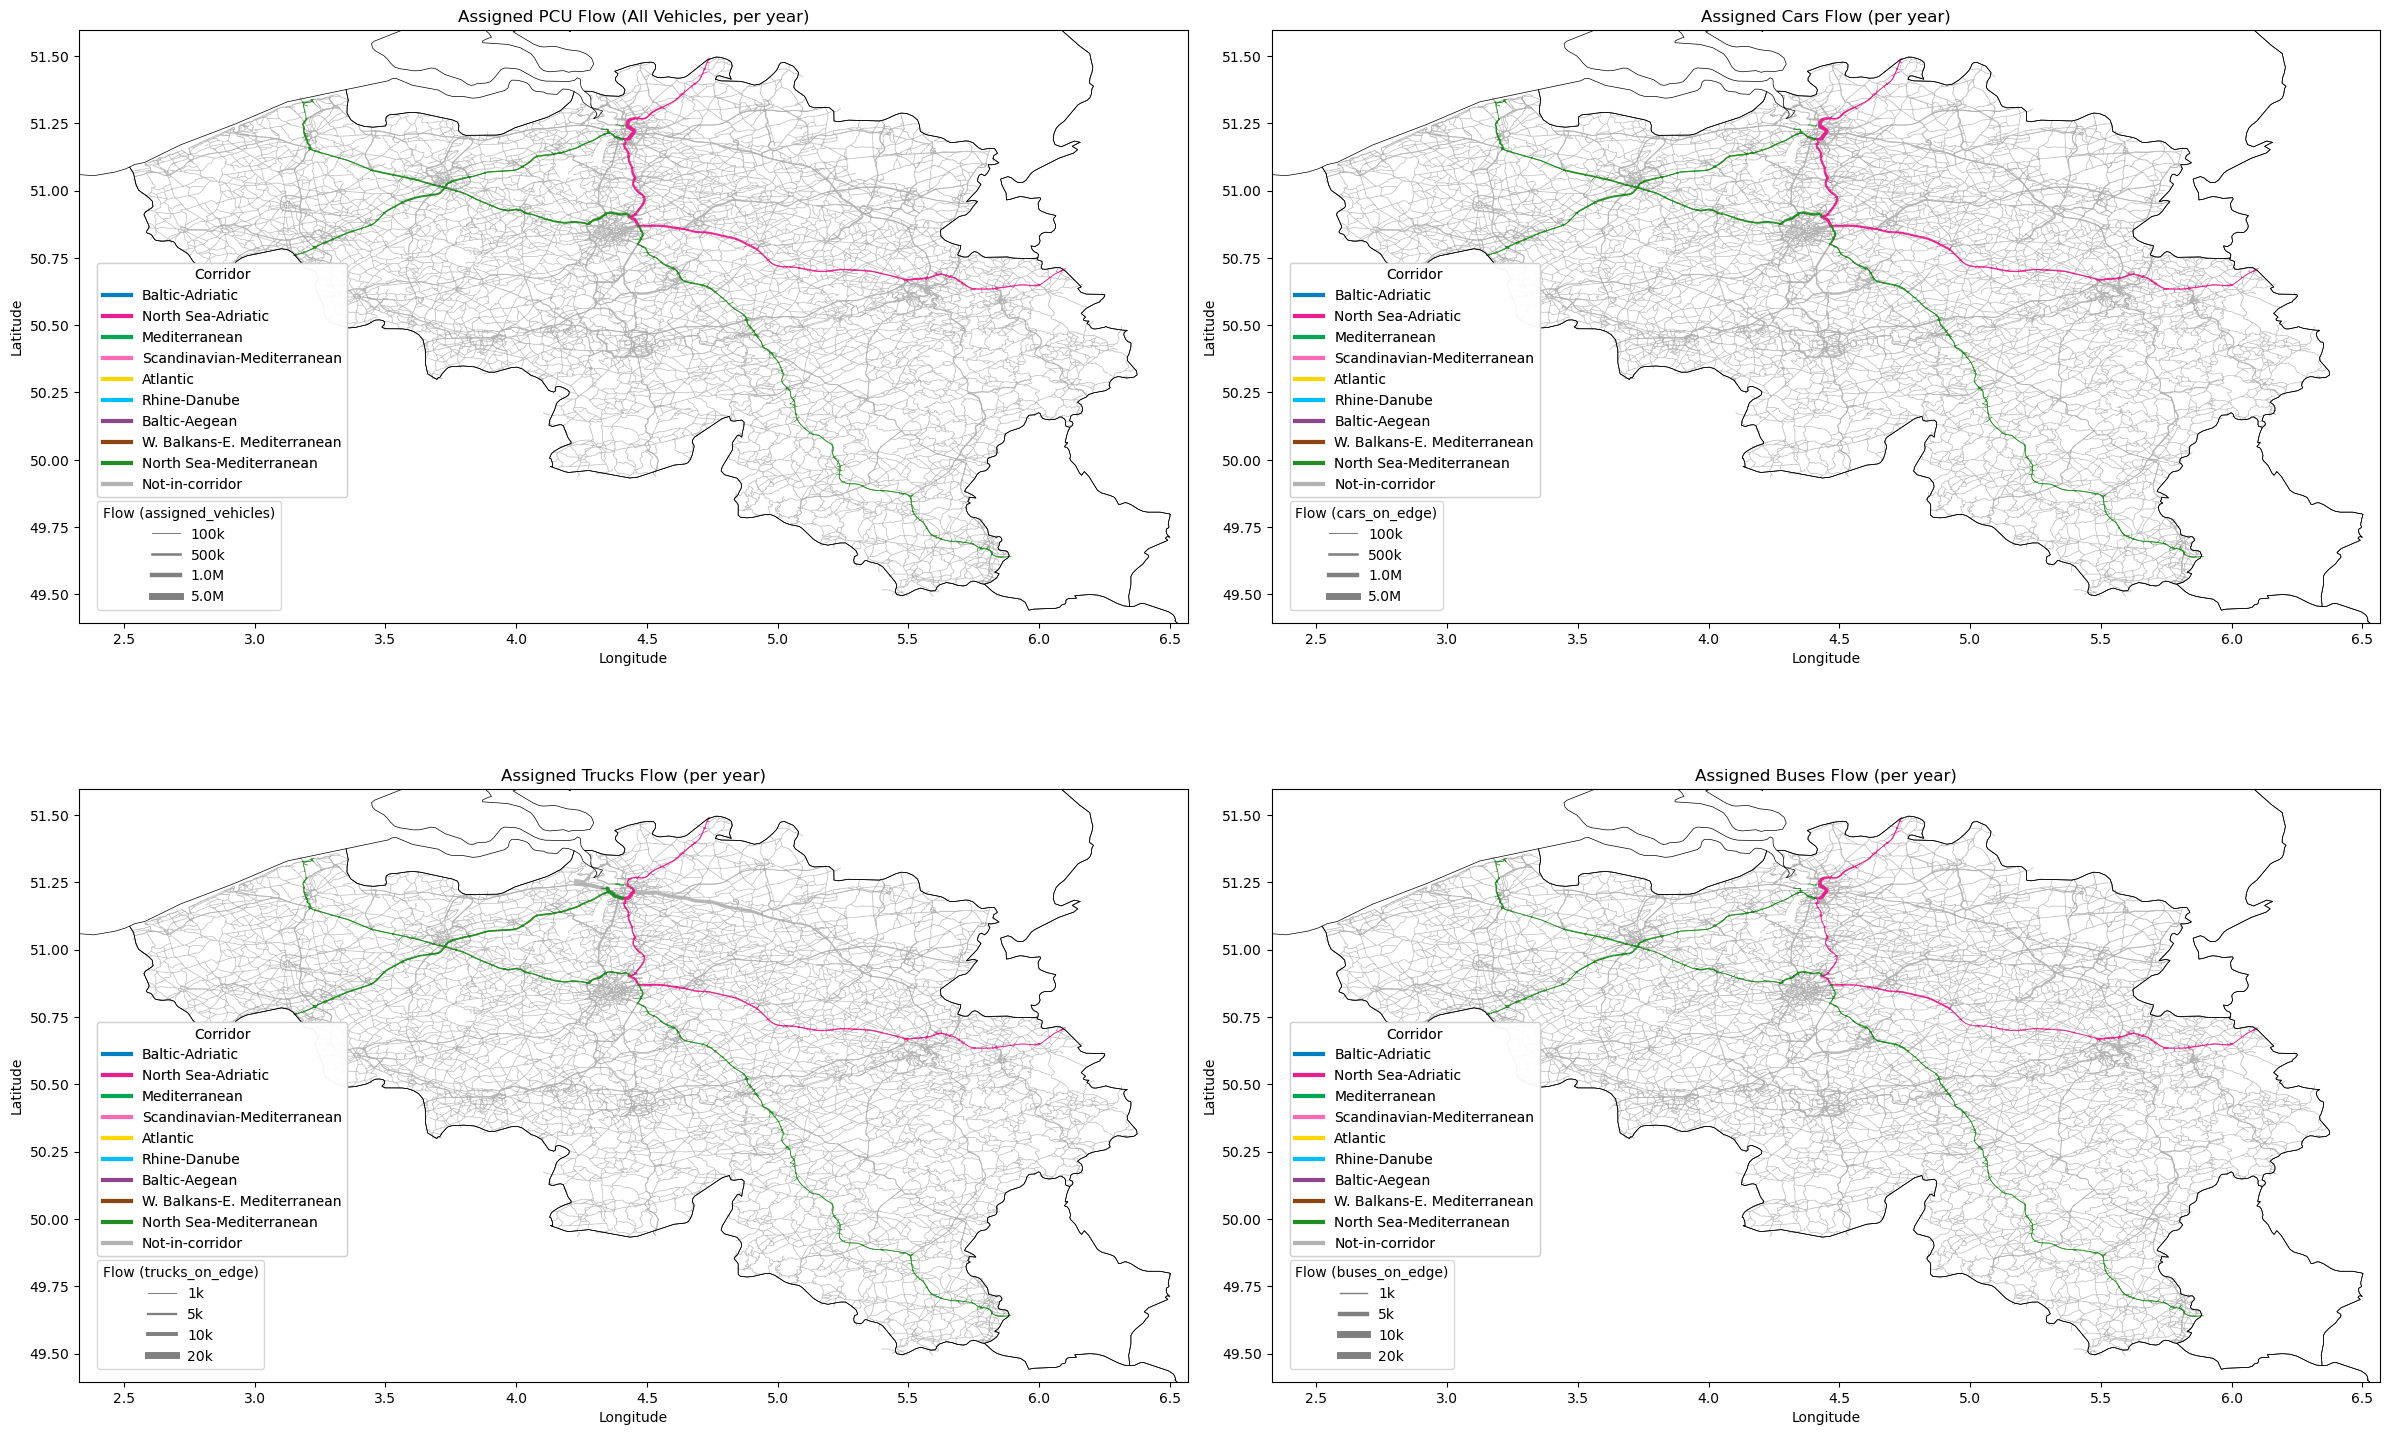

PER-EDGE VEHICLE FLOW STATISTICS
PCU (all):
  Total: 313,118,854,466
  Max:   168,140,149
  Mean:  1,673,340.68
  Nonzero edges: 108239 / 187122

Cars:
  Total: 305,882,906,780
  Max:   165,609,292
  Mean:  1,634,671.00
  Nonzero edges: 104751 / 187122

Trucks:
  Total: 1,132,263,748
  Max:   1,936,751
  Mean:  6,050.94
  Nonzero edges: 34106 / 187122

Buses:
  Total: 1,279,718,814
  Max:   842,162
  Mean:  6,838.95
  Nonzero edges: 62070 / 187122



In [7]:
# Set the selected country
SELECTED_COUNTRY = "Belgium"

# --- Plot flows for all vehicles and by vehicle type ---
fig, axes = plt.subplots(2, 2, figsize=(24, 18))
axes = axes.flatten()

# 1. All vehicles (PCU)

plot_edges_by_flow_thickness(
    axes[0],filtered_network_df, flow_col='assigned_vehicles', corridors_col='CORRIDORS',
    lw_min=0.5, lw_max=5, scale='linear', scale_div=100, legend_ticks=[100000,500000,1000000,5000000]
 )
europe_countries.boundary.plot(ax=axes[0], color='black', linewidth=0.5)
axes[0].set_title('Assigned PCU Flow (All Vehicles, per year)')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_xlim(xlim)
axes[0].set_ylim(ylim)

# 2. Cars
plot_edges_by_flow_thickness(
    axes[1],filtered_network_df, flow_col='cars_on_edge', corridors_col='CORRIDORS',
    lw_min=0.5, lw_max=5, scale='linear', scale_div=100, legend_ticks=[100000,500000,1000000,5000000]
 )
europe_countries.boundary.plot(ax=axes[1], color='black', linewidth=0.5)
axes[1].set_title('Assigned Cars Flow (per year)')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_xlim(xlim)
axes[1].set_ylim(ylim)

# 3. Trucks
plot_edges_by_flow_thickness(
    axes[2],filtered_network_df, flow_col='trucks_on_edge', corridors_col='CORRIDORS',
    lw_min=0.5, lw_max=5, scale='linear', scale_div=100, legend_ticks=[1000,5000,10000,20000]
 )
europe_countries.boundary.plot(ax=axes[2], color='black', linewidth=0.5)
axes[2].set_title('Assigned Trucks Flow (per year)')
axes[2].set_xlabel('Longitude')
axes[2].set_ylabel('Latitude')
axes[2].set_xlim(xlim)
axes[2].set_ylim(ylim)

# 4. Buses
plot_edges_by_flow_thickness(
    axes[3],filtered_network_df, flow_col='buses_on_edge', corridors_col='CORRIDORS',
    lw_min=0.5, lw_max=5, scale='linear', scale_div=100, legend_ticks=[1000,5000,10000,20000]
 )
europe_countries.boundary.plot(ax=axes[3], color='black', linewidth=0.5)
axes[3].set_title('Assigned Buses Flow (per year)')
axes[3].set_xlabel('Longitude')
axes[3].set_ylabel('Latitude')
axes[3].set_xlim(xlim)
axes[3].set_ylim(ylim)

plt.savefig(outpath / f'road_network_{SELECTED_COUNTRY.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# --- Statistics for vehicle flows per edge ---
print("="*80)
print("PER-EDGE VEHICLE FLOW STATISTICS")
print("="*80)
for col, label in zip(['assigned_vehicles','cars_on_edge','trucks_on_edge','buses_on_edge'], ['PCU (all)','Cars','Trucks','Buses']):
    if col in filtered_network_df.columns:
        vals = filtered_network_df[col].fillna(0)
        print(f"{label}:")
        print(f"  Total: {vals.sum():,.0f}")
        print(f"  Max:   {vals.max():,.0f}")
        print(f"  Mean:  {vals.mean():,.2f}")
        print(f"  Nonzero edges: {(vals>0).sum()} / {len(vals)}")
        print()